# Advanced Lane Finding - Project 4 of CarND program

## Undistort image calculation based on Chessboard patterns

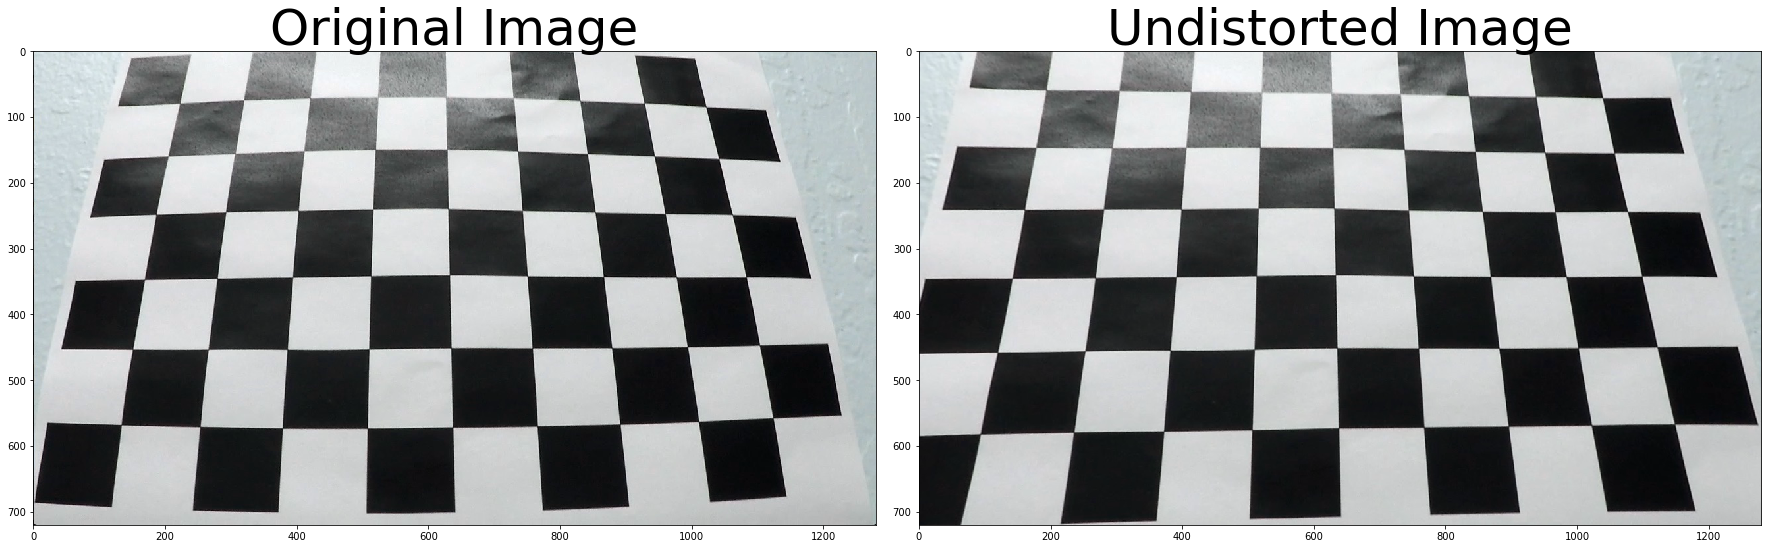

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

nx = 9
ny = 6

images = glob.glob("./camera_cal/calibration*.jpg")

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

def cal_undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return (ret, mtx, dist, undist)

fname_one = "./camera_cal/calibration3.jpg"
img = cv2.imread(fname_one)
ret, mtx, dist, undst = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/undistorted_chessboard.png")
plt.show()

## Undistort and unWarp the chessboard Pattern

### This code cell below will also help us get the Perspective Transform Matrix that we will need to transform back and forth the lane polygon

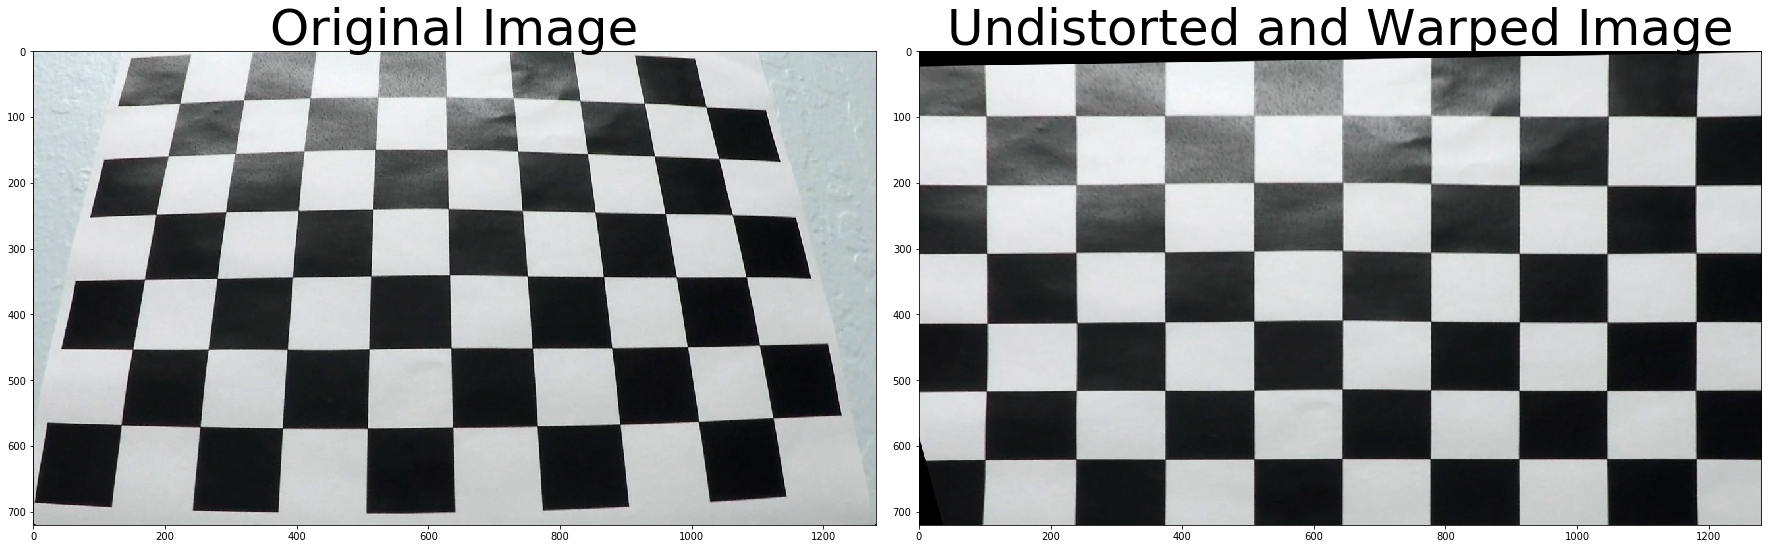

In [30]:
def corners_unwarp(img, nx, ny, mtx, dist):
    ret1, mtx, dist, undist = cal_undistort(img)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                          [img_size[0]-offset, img_size[1]-offset], 
                          [offset, img_size[1]-offset]])

        M = cv2.getPerspectiveTransform(src, dst)

        warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/undistorted_warped_chessboard.png")
plt.show()

## Undistort test image

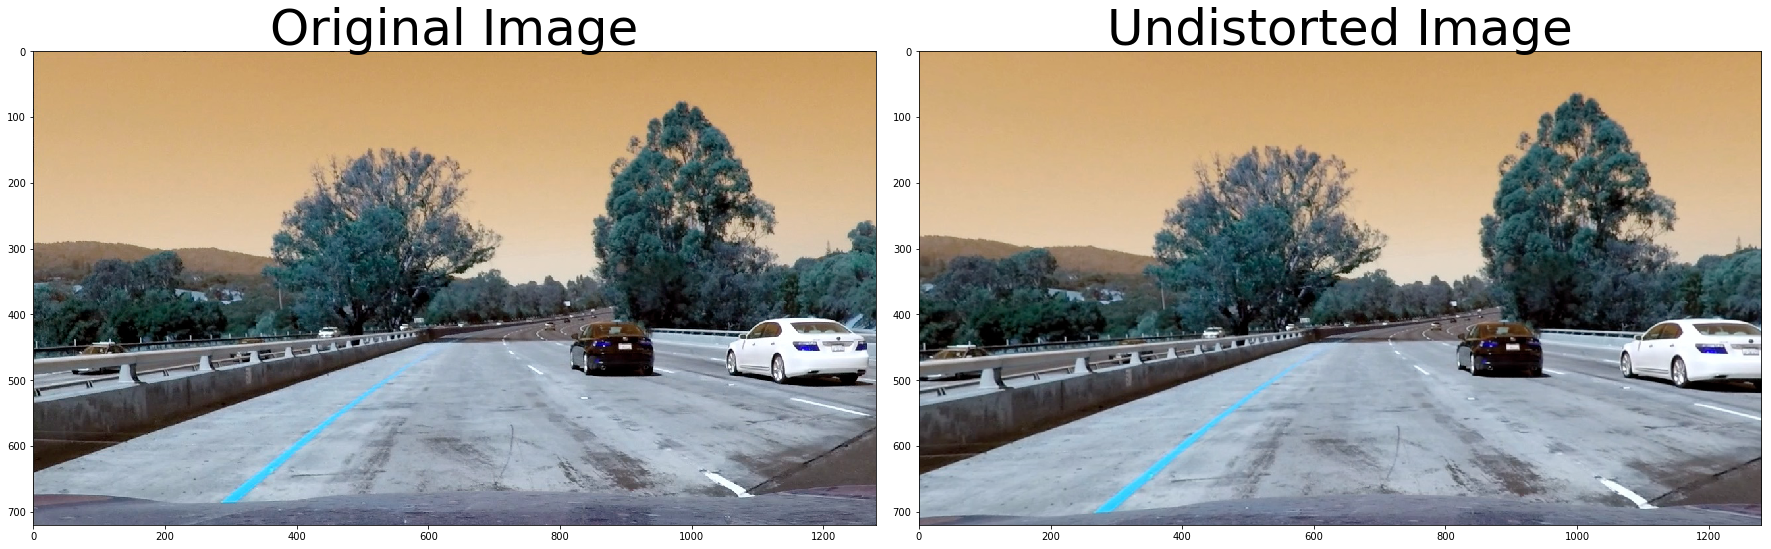

In [31]:
st_ln1 = "./test_images/test1.png"

img = cv2.imread(st_ln1)
ret, mtx, dist, undst = cal_undistort(img)

mpimg.imsave("./output_images/undistort_test1.png", undst, format="png")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/undistorted_compare_test1.png")
plt.show()

## Apply Sobel Filter

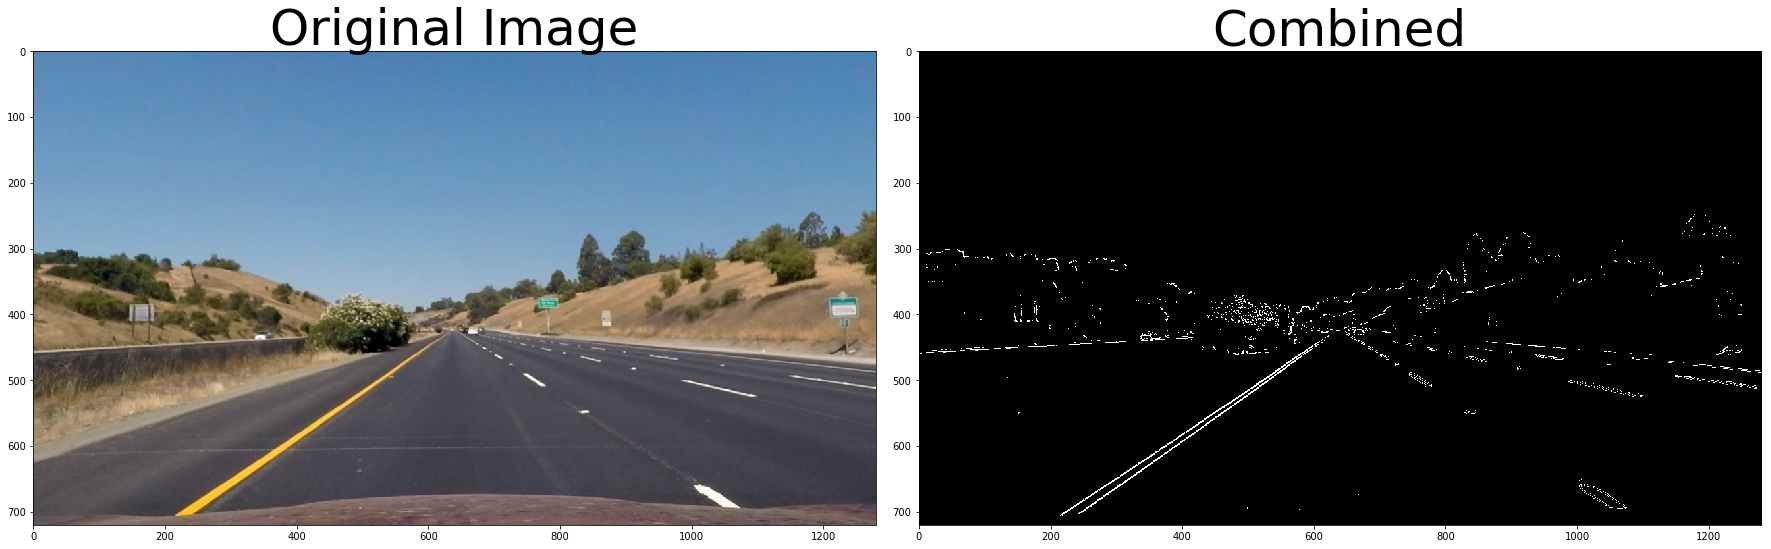

In [32]:
st_ln1 = "./test_images/straight_lines1.jpg"

def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

image = mpimg.imread(st_ln1)
ret, mtx, dist, image = cal_undistort(image)

ksize = 3
thresh = [40,100]
mag_threshs = [100,150]
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min = thresh[0], thresh_max = thresh[1])
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min = thresh[0], thresh_max = thresh[1])
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh = mag_threshs)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/sobel_output.png")
plt.show()

## Color Binary

Include Binary from the Sobel above and add it to the S channel Color Binary image

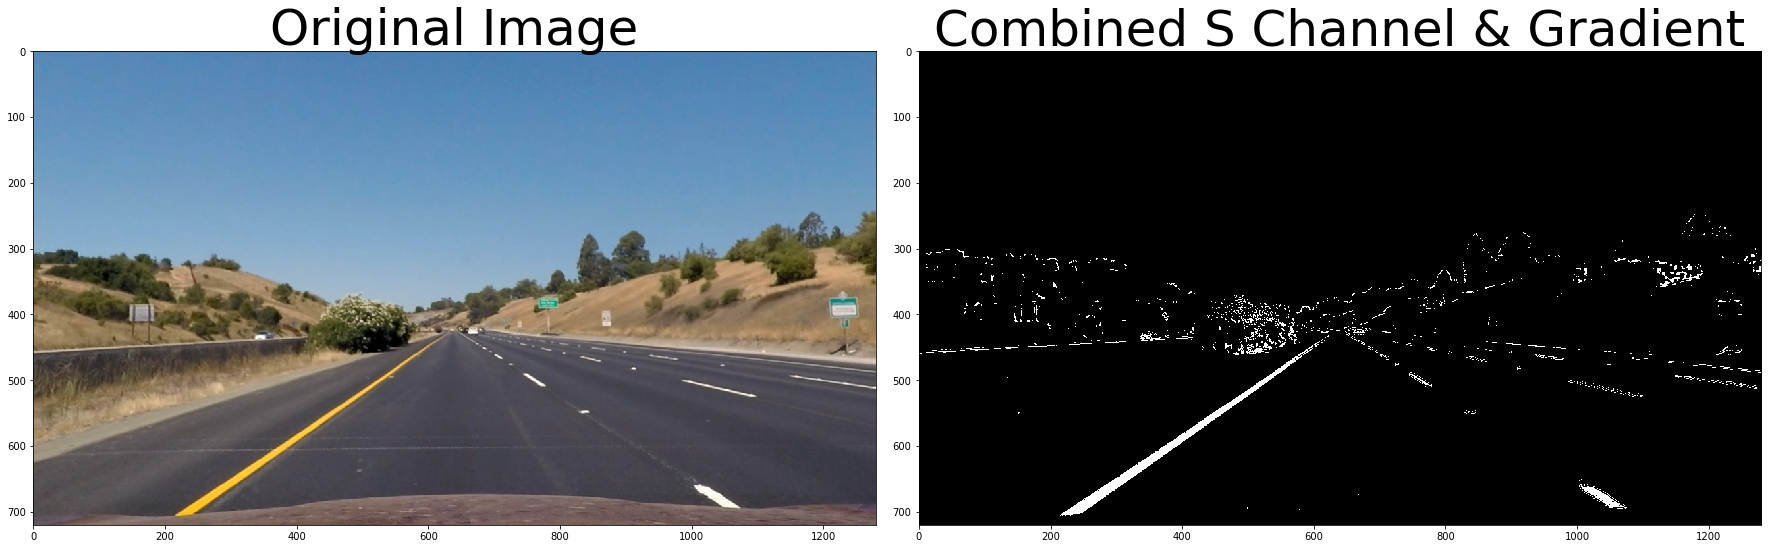

In [33]:
def getColorBinary(image, s_thresh_min=0, s_thresh_max=255):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary

s_binary = getColorBinary(image, s_thresh_min=170, s_thresh_max=255)
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1

# Plot the result
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined S Channel & Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/sobel_colorChannel.png")
plt.show()

mpimg.imsave("./output_images/combined_binary.png", combined_binary, format="png")

## Sobel and Color Binary on another test image 

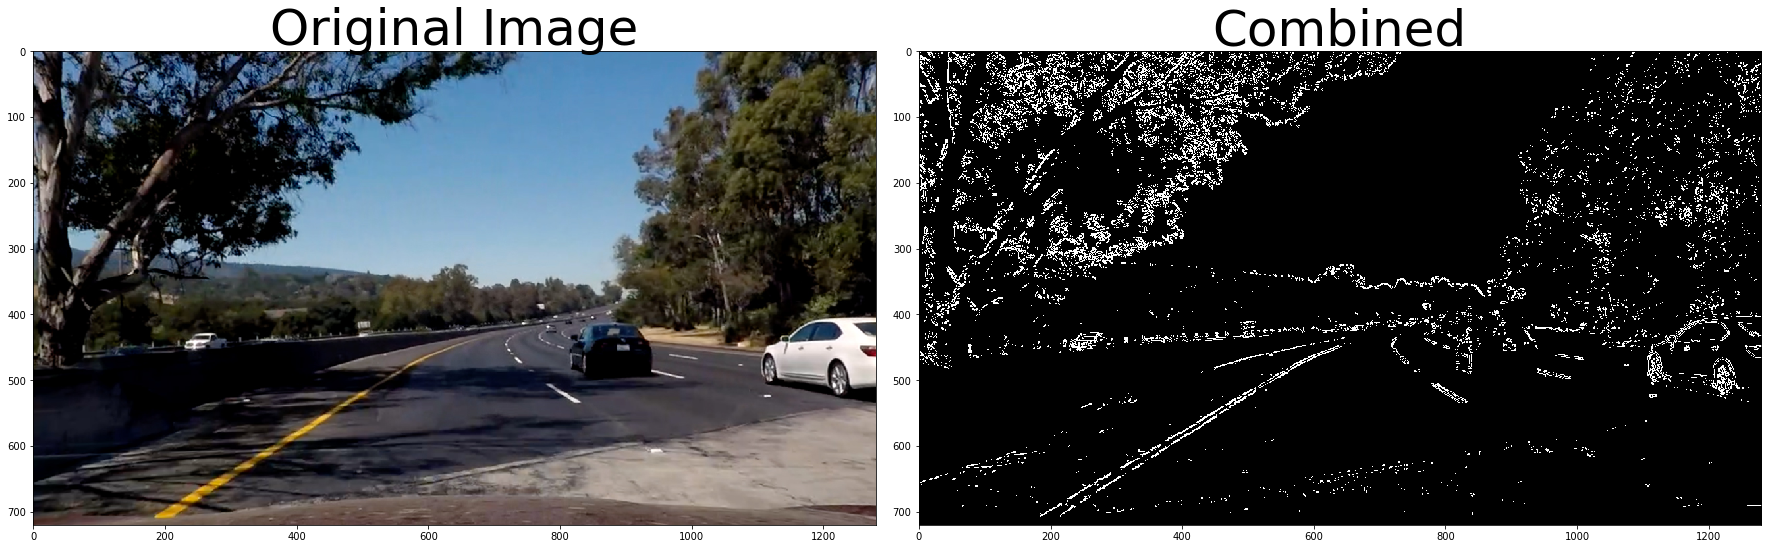

In [34]:
# Test images

#image_test1 = mpimg.imread("./test_images/test1.jpg")
#image_test1 = mpimg.imread("./test_images/test4.jpg")
#image_test1 = mpimg.imread("./test_images/test5.jpg")
image_test1 = mpimg.imread("./test_images/test7.jpg")

ret, mtx, dist, image_test1 = cal_undistort(image_test1)

ksize = 3
thresh = [20,100]
mag_threshs = [100,150]
gradx_t1 = abs_sobel_thresh(image_test1, orient='x', sobel_kernel=ksize, thresh_min = thresh[0], thresh_max = thresh[1])
grady_t1 = abs_sobel_thresh(image_test1, orient='y', sobel_kernel=ksize, thresh_min = thresh[0], thresh_max = thresh[1])
mag_binary_t1 = mag_thresh(image_test1, sobel_kernel=ksize, mag_thresh = mag_threshs)
dir_binary_t1 = dir_threshold(image_test1, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined_t1 = np.zeros_like(dir_binary_t1)
combined_t1[((gradx_t1 == 1) & (grady_t1 == 1)) | ((mag_binary_t1 == 1) & (dir_binary_t1 == 1))] = 1

# Plot the result
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_t1, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/sobel_output_test7.png")
plt.show()

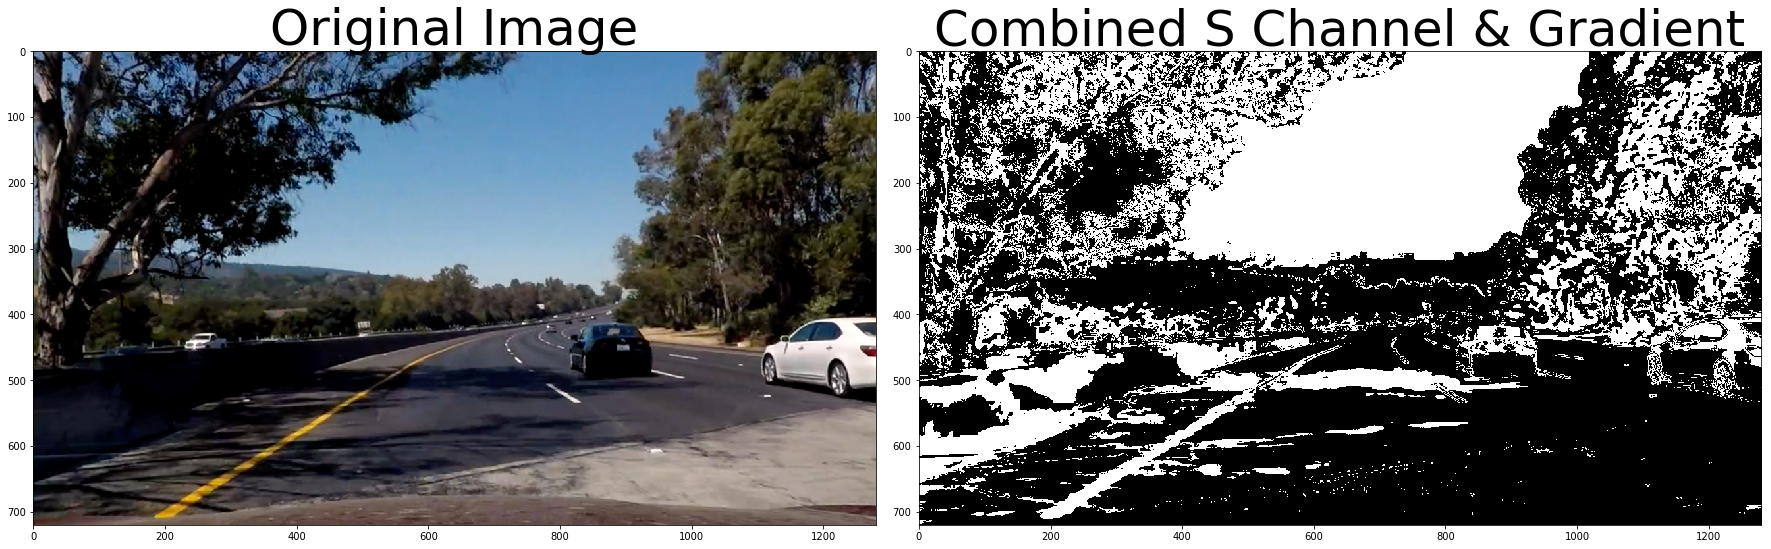

In [35]:
# Test Image

s_binary_t1 = getColorBinary(image_test1, s_thresh_min=90, s_thresh_max=255)
combined_binary_t1 = np.zeros_like(combined_t1)
combined_binary_t1[(s_binary_t1 == 1) | (combined_t1 == 1)] = 1

# Plot the result
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary_t1, cmap='gray')
ax2.set_title('Combined S Channel & Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("./output_images/sobel_colorChannel_test5.png")
plt.show()

#mpimg.imsave("./output_images/combined_binary_test5.png", combined_binary, format="png")

## Perspective Transform

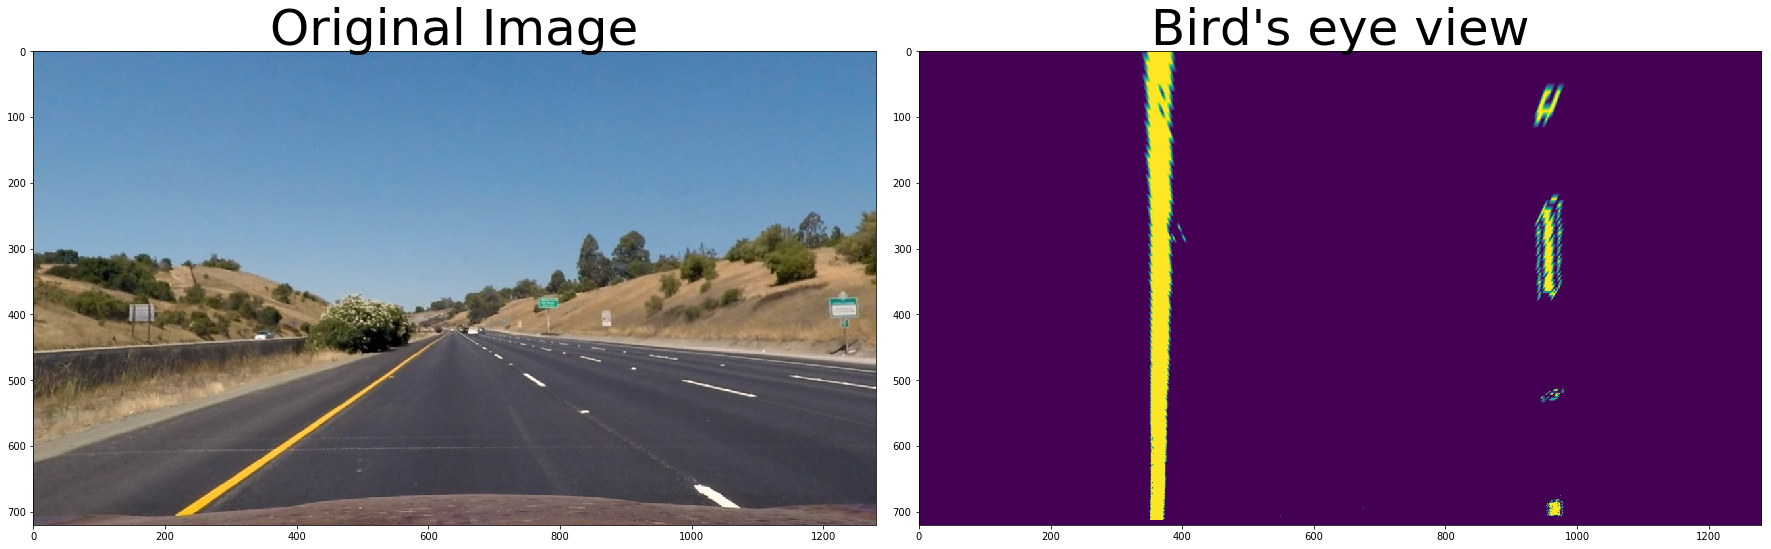

In [36]:
# Perspective Transform

#combined_binary = mpimg.imread('combined_binary.png')

def getWarped(image, binary):
    src = np.float32([[-330, image.shape[0]], [475, 470], [800, 470], [1570, image.shape[0]]])
    dst = np.float32([[0, image.shape[0]], [0, 0], [image.shape[1], 0], [image.shape[1], image.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary, M, (image.shape[1],image.shape[0]))
    
    return (M, warped)

M, binary_warped = getWarped(image, combined_binary)

plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped)
ax2.set_title("Bird's eye view", fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/binary_warped_compare.png")
plt.show()

mpimg.imsave('binary_warped.png', binary_warped, format='png')

## Extract Lane Lines

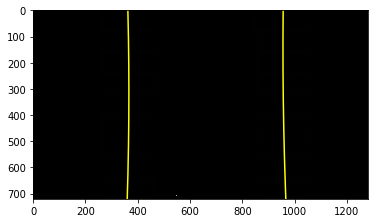

In [48]:
def getNonZeroPixels (binary_warped):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    return (nonzerox, nonzeroy)

def generateFreshLanePoints(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox, nonzeroy = getNonZeroPixels(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return (left_lane_inds, right_lane_inds, out_img)

def extract_lines(binary_warped, left_lane_inds, right_lane_inds):
    
    nonzerox, nonzeroy = getNonZeroPixels(binary_warped)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (ploty, left_fit, right_fit, left_fitx, right_fitx)

left_lane_inds, right_lane_inds, out_img = generateFreshLanePoints(binary_warped)
ploty, left_fit, right_fit, left_fitx, right_fitx = extract_lines(binary_warped, left_lane_inds, right_lane_inds)

nonzerox, nonzeroy = getNonZeroPixels(binary_warped)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("./output_images/lane_lines.png")
plt.show()

## Extract Lane Lines from Previous Lanes

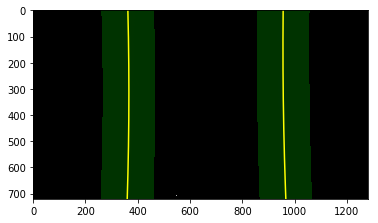

In [38]:
def generateLanePointsFromPrevious(binary_warped, left_fit, right_fit, margin=100):
    nonzerox, nonzeroy = getNonZeroPixels(binary_warped)

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    return (left_lane_inds, right_lane_inds)

left_lane_inds, right_lane_inds = generateLanePointsFromPrevious(binary_warped, left_fit, right_fit)

ploty, left_fit, right_fit, left_fitx, right_fitx = extract_lines(binary_warped, left_lane_inds, right_lane_inds)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin=100

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#cv2.fillPoly(window_img, np.int_([poly_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("./output_images/lanes_lines_margin_window.png")
plt.show()

## Radius of Curvature and Vehicle Position

In [43]:
def getRadiusOfCurvature(ploty, left_fit, right_fit, leftx, rightx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

def getDistanceFromCenter(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    #center of lane based on x positions
    centerx = (right_fitx - left_fitx)/2 + left_fitx
    dist_px = np.absolute(image.shape[1]/2 - centerx)
    dist_m = (3.7/600) * dist_px
    
    return dist_m
    

## Draw Lane

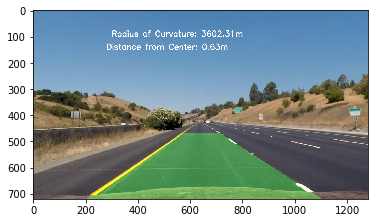

In [44]:
def drawLane(image, binary_warped, M, ploty, left_fitx, right_fitx):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

result = drawLane(image, binary_warped, M, ploty, left_fitx, right_fitx)

left_rc, right_rc = getRadiusOfCurvature(ploty, left_fit, right_fit, left_fitx, right_fitx)
dist_center = getDistanceFromCenter(ploty, left_fit, right_fit)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'Radius of Curvature: ' + "{0:.2f}".format(left_rc) + 'm', (300,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
cv2.putText(result, 'Distance from Center: ' + "{0:.2f}".format(dist_center) + 'm', (280,150), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
plt.imshow(result)
plt.show()

mpimg.imsave('./output_images/lane_lines_unwarped.png', result, format='png')

## Video Lane Extract

In [45]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

In [49]:
lane_points_exist = False
left_fit = []
right_fit = []

# Build the pipeline
def process_image(image_original):
    
    # Create global variables that will remember the lanes points from the previous frame
    global lane_points_exist, left_fit, right_fit
    
    # creating a blank to draw lines on
    image = np.copy(image_original)
    
    #Undistort the image
    ret, mtx, dist, image = cal_undistort(image)
    
    # Appy Sobel
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Apply s Channel and add Sobel binary pixels
    s_binary = getColorBinary(image, s_thresh_min=90, s_thresh_max=255)
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    M, binary_warped = getWarped(image, combined_binary)
    
    # Get fresh lane points if the lane points from previous position do not exist, else, update those points with the new ones
    
    if lane_points_exist == False:
        left_lane_inds, right_lane_inds, out_img = generateFreshLanePoints(binary_warped)
        lane_points_exist = True
    else:
        left_lane_inds, right_lane_inds = generateLanePointsFromPrevious(binary_warped, left_fit, right_fit)
    
    # extract lines
    ploty, left_fit, right_fit, left_fitx, right_fitx = extract_lines(binary_warped, left_lane_inds, right_lane_inds)
    
    # Draw Lanes
    result = drawLane(image, binary_warped, M, ploty, left_fitx, right_fitx)
    
    # Add Radius of Curvature & vehicle position from the center
    left_rc, right_rc = getRadiusOfCurvature(ploty, left_fit, right_fit, left_fitx, right_fitx)
    dist_center = getDistanceFromCenter(ploty, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature: ' + "{0:.2f}".format(left_rc) + 'm', (300,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Distance from Center: ' + "{0:.2f}".format(dist_center) + 'm', (280,150), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return result


In [47]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:30<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 14s, sys: 1min 53s, total: 18min 7s
Wall time: 14min 31s


US Highway RC
http://onlinemanuals.txdot.gov/txdotmanuals/rdw/Table_2-3_m.pdf